### Título de proyecto

"Prevención de enfermedades con ML"

### Tema

"Prevencion de ECV" 

Las enfermedades cardiovasculares (ECV) son la principal causa de muerte en todo el mundo y se cobran aproximadamente 17,9 millones de vidas cada año, lo que representa el 31 % de todas las muertes en todo el mundo. 
Este proyecto busca comparar diferentes métodos de ML hasta encontrar el mas eficiente en la deteccion de ECV's.
Poner la tecnología al servicio de la comunidad.

In [2]:
import pandas as pd
df=pd.read_csv("data/train.csv",sep=",")


In [3]:
df.drop("Unnamed: 0",axis=1,inplace=True)
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [6]:
#Comprobar que porcentaje de la variable target son 0(negativo)
((len(df[df["HeartDisease"]==0]))*100)/(len(df))

42.142857142857146

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             700 non-null    int64  
 1   Sex             700 non-null    object 
 2   ChestPainType   700 non-null    object 
 3   RestingBP       700 non-null    int64  
 4   Cholesterol     700 non-null    int64  
 5   FastingBS       700 non-null    int64  
 6   RestingECG      700 non-null    object 
 7   MaxHR           700 non-null    int64  
 8   ExerciseAngina  700 non-null    object 
 9   Oldpeak         700 non-null    float64
 10  ST_Slope        700 non-null    object 
 11  HeartDisease    700 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 65.8+ KB


Nuestro Dataframe esta relativamente balanceado.

Tenemos un Dataframe de 11 columnas y un target ("HeartDisease") sin valores nulos. Transformaremos las columnas de tipo "object" para ser tomadas por nuestro primer analisis y posteriores modelos.

In [4]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
df["Sex"]=le.fit_transform(df["Sex"])
df["ChestPainType"]=le.fit_transform(df["ChestPainType"])
df["RestingECG"]=le.fit_transform(df["RestingECG"])
df["ExerciseAngina"]=le.fit_transform(df["ExerciseAngina"])
df["ST_Slope"]=le.fit_transform(df["ST_Slope"])



Analisis Univariante:

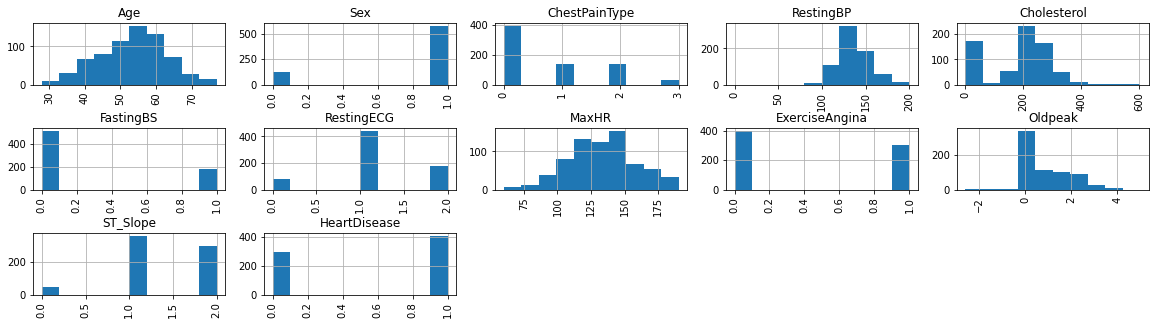

In [9]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(20, 5))
cols = 5
rows = int(np.ceil(float(df.shape[1]) / cols))
for i, column in enumerate(df.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if df.dtypes[column] == object:
        df[column].value_counts().plot(kind="bar", axes=ax)
    else:
        df[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2);

Las variables tienen sentido y sus unidades de medida son correctas.
Puede que nuestro modelo se vea sesgado por sexo debido a que va a absorber muchos mas datos masculinos que femeninos.

Analisis Multivariante:

Puesto que tenemos pocas columnas podemos permitirnos realizar un pairplot para visualizar rapidamente como estan relacionadas las variables entre ellas y con la variable target

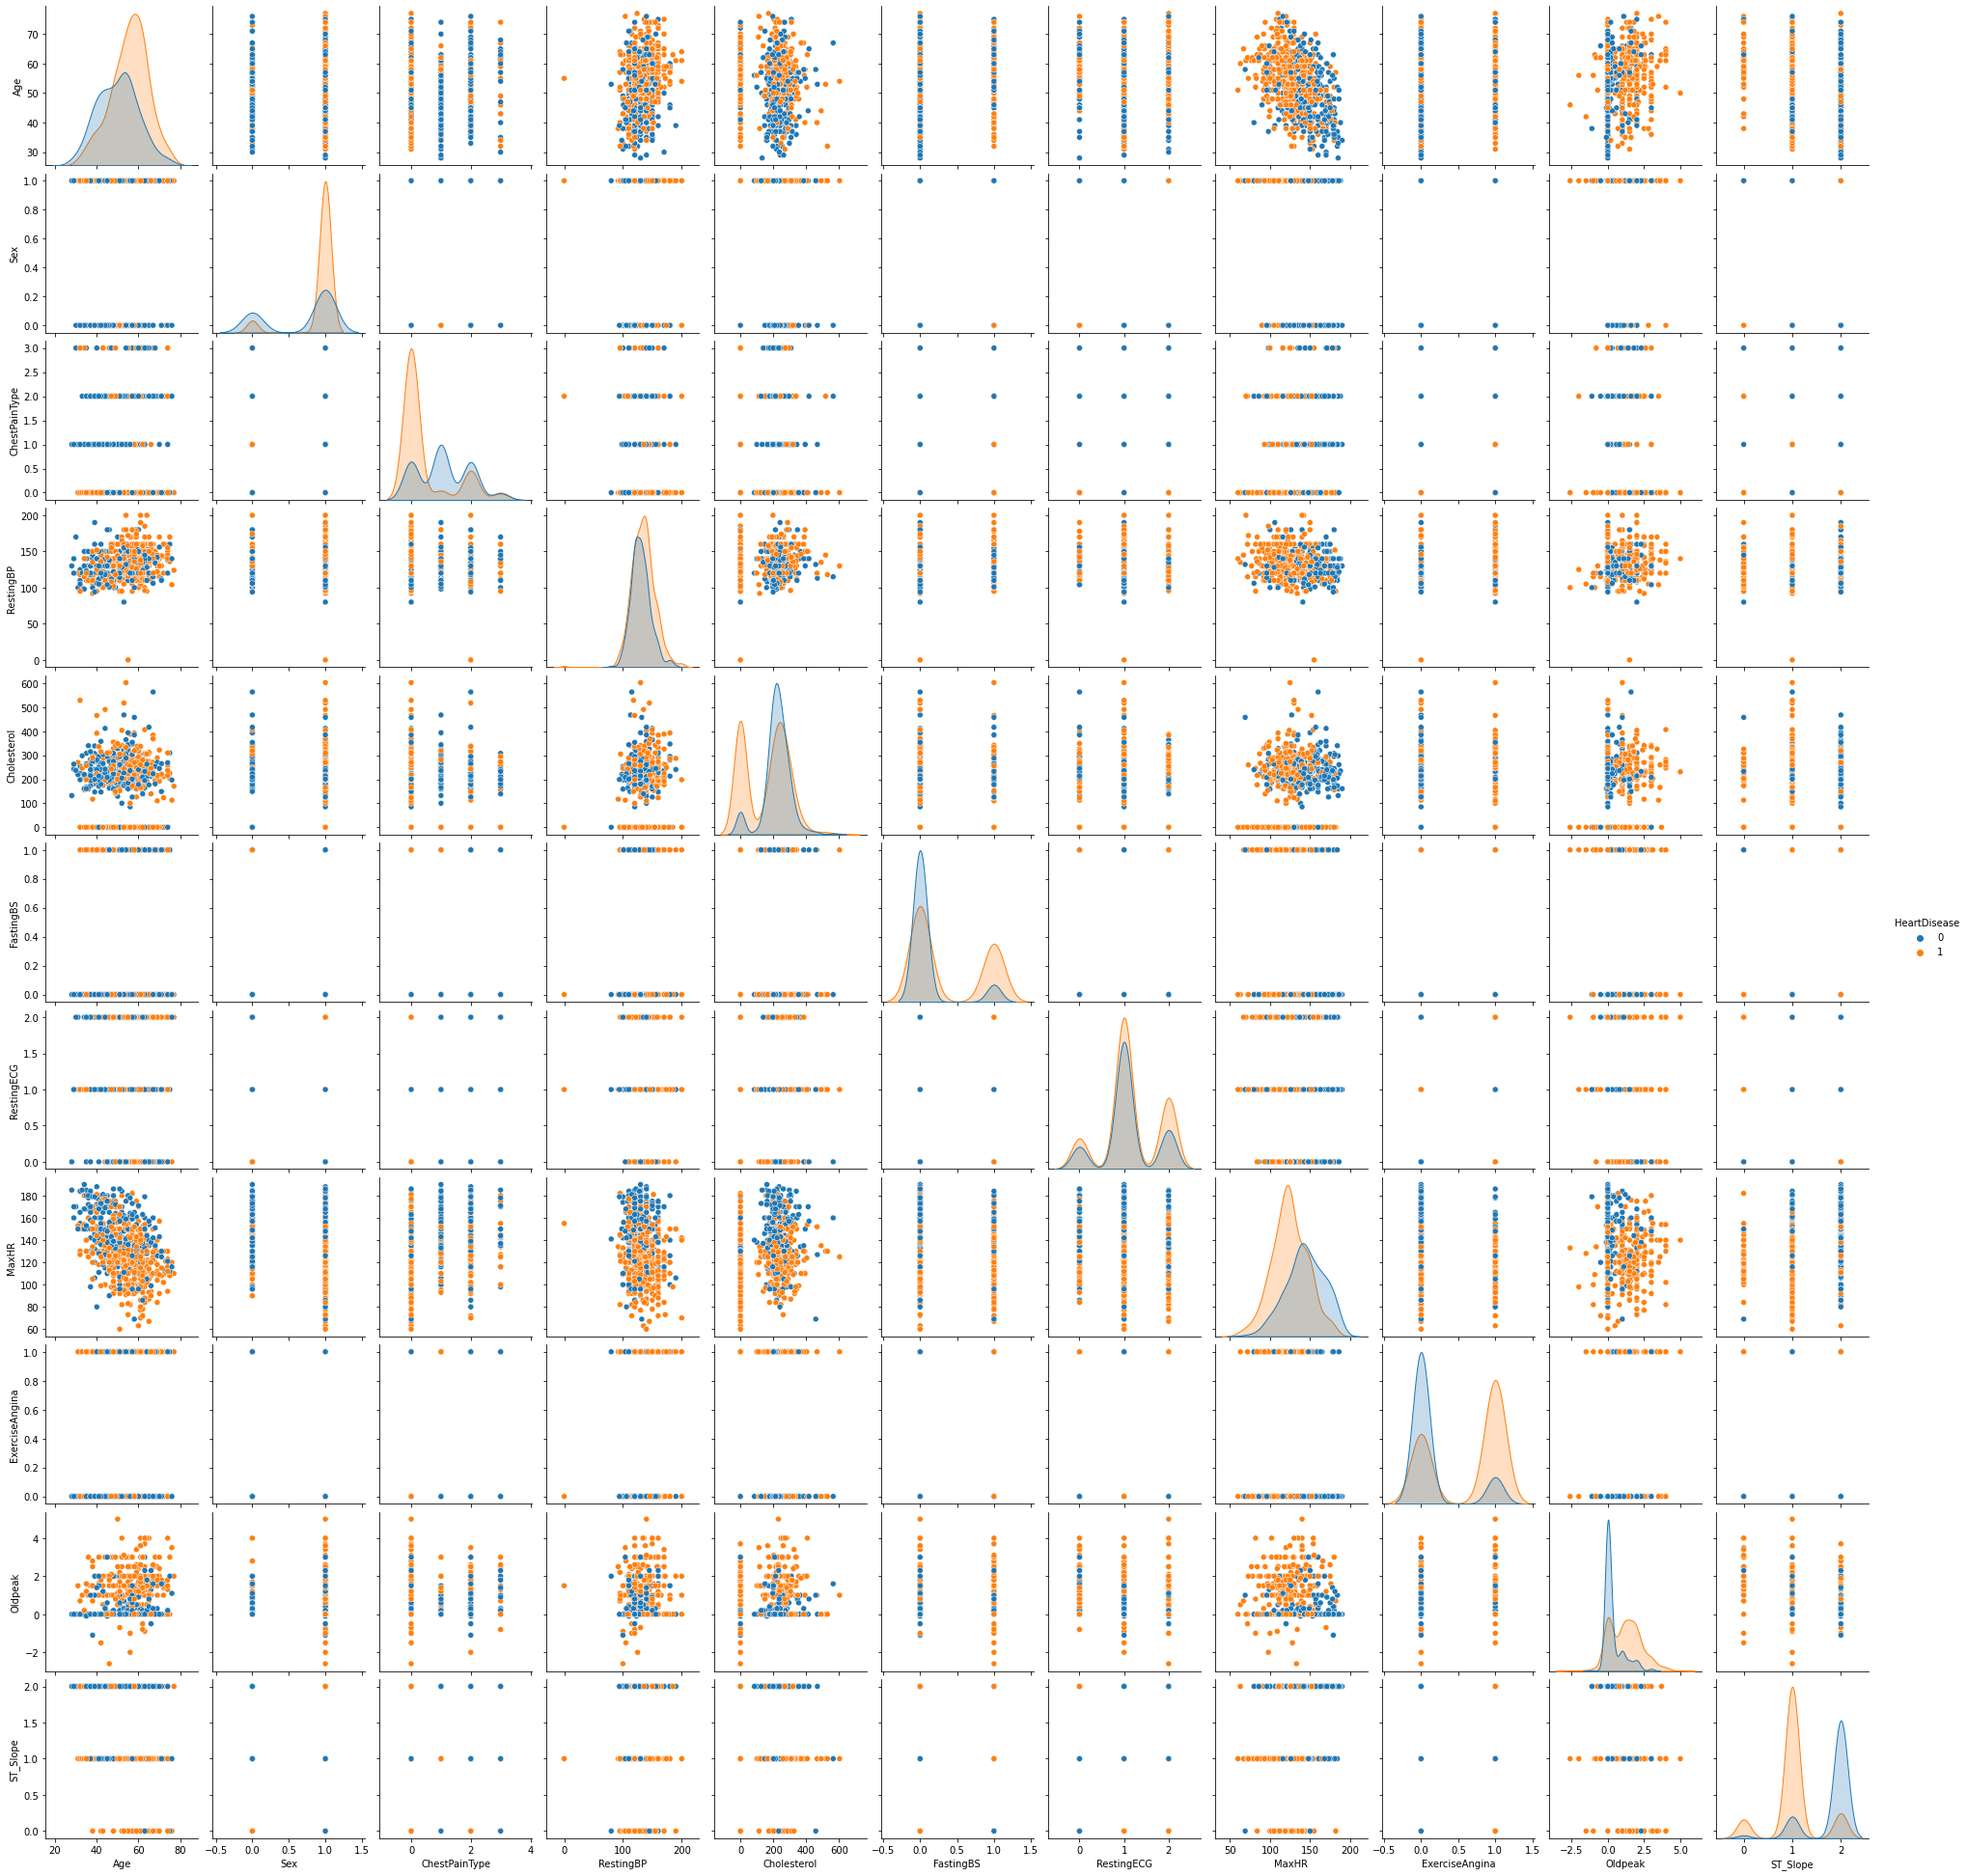

In [10]:
import seaborn as sns
sns.pairplot(df,
            kind='scatter',
            hue='HeartDisease');

Se ven claras diferencias visualmente. De primeras parece un problema a tratar con SVM

Para saber la correlación numérica de una forma visual haremos un mapa de calor intuitivo

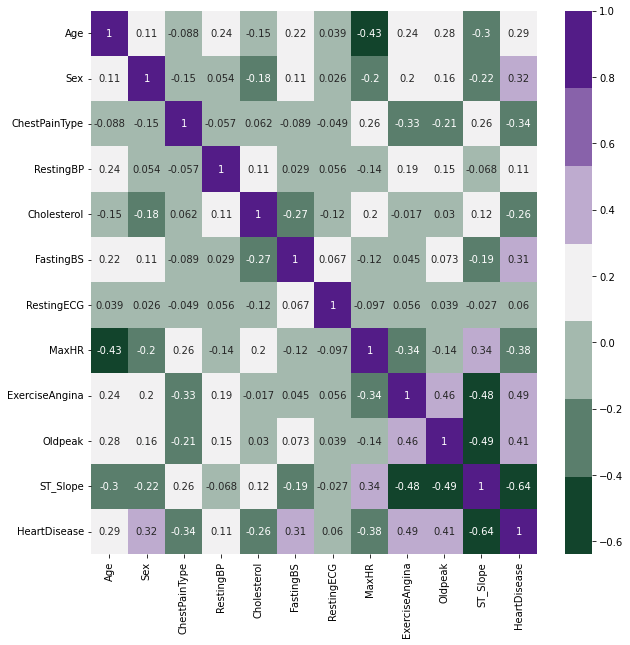

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),
           cmap=sns.diverging_palette(145, 280, s=85, l=25, n=7),
           annot=True);

Vamos a realizar algunas transformaciones y a quedarnos con aquellas que mejoren la correlación con el target

In [5]:
import funciones3 as f
f.transformChest(df)
f.transformECG(df)
f.transformST(df)

Comprobamos si hemos mejorado las correlaciones

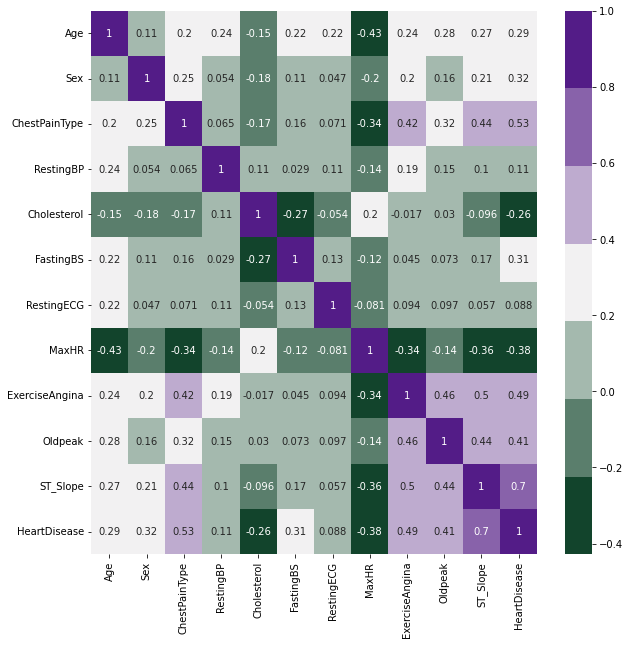

In [13]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),
           cmap=sns.diverging_palette(145, 280, s=85, l=25, n=7),
           annot=True);

Para nuestros modelos eliminaremos "ExerciseAngina" por multicolinealidad

In [6]:
X = df.drop(["HeartDisease","ExerciseAngina"], axis=1)
y = df['HeartDisease'].copy()

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1)

Vamos a entrenar unos cuantos modelos de clasificación con Pipeline (donde utilizaremos PCA para omitir columnas sin varianza y StandardScaler en aquellos modelos que no sean arboles) que meteremos en un gridsearch con diferentes parámetros. Si queremos probar demasiados parámetros utilizaremos un RandomSearch.

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost

xgb_clas = Pipeline([('pca', PCA()),
                    ("scaler",StandardScaler()),
                    ("xgboost",xgboost.XGBRFClassifier())
                   ])

gbct = GradientBoostingClassifier()


knn = Pipeline([    ('pca', PCA()),
                    ("scaler",StandardScaler()),
                    ("knn",KNeighborsClassifier())
                   ])

rand_forest = Pipeline([    ('pca', PCA()),
                            ('randf',RandomForestClassifier())
                            ])

svm = Pipeline([("scaler",StandardScaler()),
                ('pca', PCA()),
                ("selectkbest",SelectKBest()),
                ("svm",SVC())
               ])


reg_log = Pipeline([("scaler",StandardScaler()),
                    ("reglog",LogisticRegression())
                   ])

xgb_clas_param={     'pca__n_components': [5,6,7,8,9],
                    "xgboost__n_estimators": [80,90,100,110,120],
                     "xgboost__max_depth": [2,3,4,5,6],
                     "xgboost__learning_rate":[0.4,0.5,0.6,0.7,0.8,1,1.2,1.3]                        
                     }

rand_forest_param = {'pca__n_components': [5,6,7,8,9],
                    "randf__n_estimators": [100,110,120,140,150,160,200],
                     "randf__max_depth": [3,4,5,6,8,9,10,11,12,15,17],
                     "randf__max_features": ["sqrt", 3, 4]                          
                     }

gbct_param={        "n_estimators": [100,120,150],
                     "max_depth": [2,3,4,5,6],
                     "learning_rate":[0.8,1,1.3]                        
                     }

knn_param= {'pca__n_components': [3,4,5,6,7,8,9],
            "knn__n_neighbors":np.arange(1,500,2)}

svm_param = {
            'pca__n_components': [3,4,5,6,7,8,9],         
            'selectkbest__k': [1,2,3],
            'svm__C': [0.1,0.2, 0.4, 0.5, 0.6], 
            'svm__kernel': ["poly"],
            'svm__coef0': [-10.,-1., 0., 0.1, 0.5, 1,3, 5,10],
            'svm__gamma': ('scale', 'auto')
            }


reg_log_param = { 
                 "reglog__penalty": ["l1","l2"], 
                 "reglog__C": np.logspace(0, 2,4, 6,10)
                }


gs_rand_forestR = GridSearchCV(rand_forest,
                         rand_forest_param,
                         cv = 7,
                         scoring = 'recall',
                         verbose = 1,
                         n_jobs = -1)

gs_svmR = GridSearchCV(svm,
                         svm_param,
                         cv = 7,
                         scoring = 'recall',
                         verbose = 1,
                         n_jobs = -1)

gs_xgb_clasR = GridSearchCV(xgb_clas,
                         xgb_clas_param,
                         cv = 7,
                         scoring = 'recall',
                         verbose = 1,
                         n_jobs = -1)

gs_gbctR = GridSearchCV(gbct,
                         gbct_param,
                         cv = 7,
                         scoring = 'recall',
                         verbose = 1,
                         n_jobs = -1)

gs_knnR = RandomizedSearchCV(knn,
                         knn_param,
                         n_iter=150,
                         cv = 7,
                         scoring = 'recall',
                         verbose = 1,
                         n_jobs = -1)

grids = {
        "gs_rand_forest": gs_rand_forestR,
        "gs_knn":gs_knnR,
        "gs_gbct":gs_gbctR,
        "gs_xgb_clas":gs_xgb_clasR,
        "gs_svm": gs_svmR
        }

for nombre, grid_search in grids.items():
    grid_search.fit(X_train, y_train)

best_grids = [(i, j.best_score_) for i, j in grids.items()]

best_grids = pd.DataFrame(best_grids, columns=["Grid", "Best score"]).sort_values(by="Best score", ascending=False)
best_grids

Fitting 7 folds for each of 1155 candidates, totalling 8085 fits
Fitting 7 folds for each of 150 candidates, totalling 1050 fits


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_search.py:972: UserWarning: One or more of the test scores are non-finite: [0.91984127 0.96154401 1.         0.95829726 0.89090909 1.
 0.94227994 0.95836941 0.98722944 0.96479076 0.98088023 0.98405483
 1.         0.91630592 0.86854257 0.85584416 0.93268398 0.92936508
 0.93910534 0.88816739 0.95505051 0.96154401 1.         0.89437229
 1.         0.93910534 0.89718615 0.90685426 0.98080808 0.9968254
 0.91688312 0.93275613 0.94227994 0.93261183 0.93924964 0.96796537
        nan 0.91976912 0.94235209 0.9487013         nan        nan
 1.         1.         1.         0.94242424 0.9968254  0.96803752
 0.9487013  1.         0.91984127 0.93903319 0.92604618 0.92287157
 1.         0.92323232 0.87821068 0.9968254  0.94877345 1.
 0.92316017 0.97113997 0.96796537 0.99047619 0.9518759  0.91673882
 0.86529582 1.         0.99040404 0.90728716 0.92294372 0.92950938
 0.86536797        nan 0.94235209 0.91659

Fitting 7 folds for each of 45 candidates, totalling 315 fits
Fitting 7 folds for each of 1000 candidates, totalling 7000 fits


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:10:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 7 folds for each of 1890 candidates, totalling 13230 fits


,Grid,Best score
1,gs_knn,1.000000
4,gs_svm,0.974531
0,gs_rand_forest,0.955195
3,gs_xgb_clas,0.952020
2,gs_gbct,0.910678


Esto son datos de entrenamiento bajo la metrica de recall, vamos a ver sobre la parte de test que nos habiamos reservado

In [18]:
from sklearn.metrics import accuracy_score,precision_score, recall_score
accuracy=[]
recall=[]
grids = {
        "gs_rand_forest": gs_rand_forestR,
        "gs_knn":gs_knnR,
        "gs_gbct":gs_gbctR,
        "gs_xgb_clas":gs_xgb_clasR,
        "gs_svm": gs_svmR
        }
        
for i in grids.values():
    preds = i.best_estimator_.predict(X_test)
    accuracy.append(accuracy_score(y_test, preds))
    recall.append(recall_score(y_test,preds))

best_predict=pd.DataFrame(grids.keys())
best_predict["recall"]=recall
best_predict["accuracy"]=accuracy
best_predict.sort_values(by="recall", ascending=False)



,0,recall,accuracy
1,gs_knn,0.978261,0.821429
4,gs_svm,0.956522,0.828571
2,gs_gbct,0.923913,0.892857
0,gs_rand_forest,0.902174,0.885714
3,gs_xgb_clas,0.902174,0.871429


Desconfio que KNN se halla ajustado perfectamente a los datos de entrenamiento y después pierda tanta accuracy.Probablemente estemos ante un caso de Overfiting.Lo comprobaremos mas adelante prediciendo un conjunto de datos mayor como es el dataset "Test".

Vamos a hacer lo mismo que antes bajo la métrica de "accuracy" sin dejar de lado el "recall".

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost

xgb_clas = Pipeline([('pca', PCA()),
                    ("scaler",StandardScaler()),
                    ("xgboost",xgboost.XGBRFClassifier())
                   ])

gbct = GradientBoostingClassifier()


knn = Pipeline([    ('pca', PCA()),
                    ("scaler",StandardScaler()),
                    ("knn",KNeighborsClassifier())
                   ])

rand_forest = Pipeline([    ('pca', PCA()),
                            ('randf',RandomForestClassifier())
                            ])

svm = Pipeline([("scaler",StandardScaler()),
                ('pca', PCA()),
                ("selectkbest",SelectKBest()),
                ("svm",SVC())
               ])


reg_log = Pipeline([("scaler",StandardScaler()),
                    ("reglog",LogisticRegression())
                   ])

xgb_clas_param={     'pca__n_components': [5,6,7,8,9],
                    "xgboost__n_estimators": [80,90,100,110,120],
                     "xgboost__max_depth": [2,3,4,5,6],
                     "xgboost__learning_rate":[0.4,0.5,0.6,0.7,0.8,1,1.2,1.3]                        
                     }

rand_forest_param = {'pca__n_components': [5,6,7,8,9],
                    "randf__n_estimators": [100,110,120,140,150,160,200],
                     "randf__max_depth": [3,4,5,6,8,9,10,11,12,15,17],
                     "randf__max_features": ["sqrt", 3, 4]                          
                     }

gbct_param={        "n_estimators": [100,120,150],
                     "max_depth": [2,3,4,5,6],
                     "learning_rate":[0.8,1,1.3]                        
                     }

knn_param= {'pca__n_components': [3,4,5,6,7,8,9],
            "knn__n_neighbors":np.arange(1,500,2)}

svm_param = {
            'pca__n_components': [3,4,5,6,7,8,9],         
            'selectkbest__k': [1,2,3],
            'svm__C': [0.1,0.2, 0.4, 0.5, 0.6], 
            'svm__kernel': ["poly"],
            'svm__coef0': [-10.,-1., 0., 0.1, 0.5, 1,3, 5,10],
            'svm__gamma': ('scale', 'auto')
            }


reg_log_param = { 
                 "reglog__penalty": ["l1","l2"], 
                 "reglog__C": np.logspace(0, 2,4, 6,10)
                }


gs_rand_forest = GridSearchCV(rand_forest,
                         rand_forest_param,
                         cv = 7,
                         scoring = 'accuracy',
                         verbose = 1,
                         n_jobs = -1)

gs_svm = GridSearchCV(svm,
                         svm_param,
                         cv = 7,
                         scoring = 'accuracy',
                         verbose = 1,
                         n_jobs = -1)

gs_xgb_clas = GridSearchCV(xgb_clas,
                         xgb_clas_param,
                         cv = 7,
                         scoring = 'accuracy',
                         verbose = 1,
                         n_jobs = -1)

gs_gbct = GridSearchCV(gbct,
                         gbct_param,
                         cv = 7,
                         scoring = 'accuracy',
                         verbose = 1,
                         n_jobs = -1)

gs_knn = RandomizedSearchCV(knn,
                         knn_param,
                         n_iter=150,
                         cv = 7,
                         scoring = 'accuracy',
                         verbose = 1,
                         n_jobs = -1)

grids = {
        "gs_rand_forest": gs_rand_forest,
        "gs_knn":gs_knn,
        "gs_gbct":gs_gbct,
        "gs_xgb_clas":gs_xgb_clas,
        "gs_svm": gs_svm
        }

for nombre, grid_search in grids.items():
    grid_search.fit(X_train, y_train)

best_grids = [(i, j.best_score_) for i, j in grids.items()]

best_grids = pd.DataFrame(best_grids, columns=["Grid", "Best score"]).sort_values(by="Best score", ascending=False)
best_grids

Fitting 7 folds for each of 1155 candidates, totalling 8085 fits
Fitting 7 folds for each of 150 candidates, totalling 1050 fits


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_search.py:972: UserWarning: One or more of the test scores are non-finite: [0.55892857 0.86607143 0.675      0.80357143 0.87142857 0.85178571
 0.86964286 0.88035714 0.75357143 0.86607143 0.87857143 0.72678571
 0.87857143 0.88214286 0.86071429 0.86785714 0.80714286 0.88214286
 0.87857143 0.55892857 0.87321429 0.86428571 0.86964286 0.85892857
 0.81785714 0.78571429 0.86071429 0.84107143 0.86964286 0.63214286
 0.81428571 0.68571429 0.80357143 0.85892857 0.575      0.55892857
 0.85              nan 0.55892857 0.80178571 0.55892857 0.8625
 0.83035714 0.74285714 0.83571429 0.87857143 0.85178571 0.55892857
 0.55892857 0.55892857 0.55892857 0.8        0.86071429 0.55892857
 0.55892857 0.7875     0.87857143 0.73571429 0.68571429 0.87857143
 0.86428571 0.86428571 0.88571429 0.85714286 0.55892857 0.55892857
 0.86607143 0.83928571 0.87321429 0.87857143 0.8625     0.86607143
 0.85892857 0.88392857      

Fitting 7 folds for each of 45 candidates, totalling 315 fits
Fitting 7 folds for each of 1000 candidates, totalling 7000 fits


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:29:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 7 folds for each of 1890 candidates, totalling 13230 fits


,Grid,Best score
0,gs_rand_forest,0.901786
3,gs_xgb_clas,0.892857
1,gs_knn,0.885714
4,gs_svm,0.880357
2,gs_gbct,0.873214


Probamos con la parte de test reservada del dataset train:

In [20]:
accuracy=[]
recall=[]
grids = {
        "gs_rand_forest": gs_rand_forest,
        "gs_knn":gs_knn,
        "gs_gbct":gs_gbct,
        "gs_xgb_clas":gs_xgb_clas,
        "gs_svm": gs_svm
        }
        
for i in grids.values():
    preds = i.best_estimator_.predict(X_test)
    accuracy.append(accuracy_score(y_test, preds))
    recall.append(recall_score(y_test,preds))

best_predict=pd.DataFrame(grids.keys())
best_predict["recall"]=recall
best_predict["accuracy"]=accuracy
best_predict.sort_values(by="accuracy", ascending=False)

,0,recall,accuracy
1,gs_knn,0.923913,0.900000
2,gs_gbct,0.934783,0.900000
4,gs_svm,0.923913,0.892857
0,gs_rand_forest,0.902174,0.878571
3,gs_xgb_clas,0.891304,0.871429


In [9]:
import optuna

In [10]:
test=pd.read_csv("data/test.csv")
test=test.drop("Unnamed: 0",axis=1)

In [11]:
R=test["HeartDisease"].copy()
P=test.drop(["HeartDisease","ExerciseAngina"],axis=1)


In [44]:
P.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,Oldpeak,ST_Slope
0,42,1,43,148,244,0,56,178,0.8,19
1,62,1,13,128,208,1,56,140,0.0,19
2,59,1,43,178,270,0,56,145,4.2,77
3,41,0,13,126,306,0,51,163,0.0,19
4,50,1,79,150,243,0,56,128,2.6,82


Le realizamos a este dataset las mismas modificaciones a este dataset que al anterior

In [12]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
P["Sex"]=le.fit_transform(P["Sex"])
P["ChestPainType"]=le.fit_transform(P["ChestPainType"])
P["RestingECG"]=le.fit_transform(P["RestingECG"])

P["ST_Slope"]=le.fit_transform(P["ST_Slope"])

f.transformChest(P)
f.transformECG(P)
f.transformST(P)


Predicciones de modelos de gridsearch y randomsearch bajo el parametro que buscan maximizar el "accuracy":

In [36]:
accuracy=[]
recall=[]
grids = {
        "gs_rand_forest": gs_rand_forest,
        "gs_knn":gs_knn,
        "gs_gbct":gs_gbct,
        "gs_xgb_clas":gs_xgb_clas,
        "gs_svm": gs_svm
        }
        
for i in grids.values():
    model1 = i.best_estimator_.fit(X,y)
    pred=model1.predict(P)
    accuracy.append(accuracy_score(R, pred))
    recall.append(recall_score(R,pred))

best_predict=pd.DataFrame(grids.keys())
best_predict["recall"]=recall
best_predict["accuracy"]=accuracy
best_predict.sort_values(by="recall", ascending=False)

[01:34:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


,0,recall,accuracy
4,gs_svm,0.776699,0.798165
0,gs_rand_forest,0.737864,0.724771
1,gs_knn,0.737864,0.688073
3,gs_xgb_clas,0.708738,0.715596
2,gs_gbct,0.699029,0.738532


Ahora los modelos de gridsearch y randomsearch que buscaba maximizar el recall

In [37]:
accuracy=[]
recall=[]
grids = {
        "gs_rand_forest": gs_rand_forestR,
        "gs_knn":gs_knnR,
        "gs_gbct":gs_gbctR,
        "gs_xgb_clas":gs_xgb_clasR,
        "gs_svm": gs_svmR
        }
        
for i in grids.values():
    model1 = i.best_estimator_.fit(X,y)
    pred=model1.predict(P)
    accuracy.append(accuracy_score(R, pred))
    recall.append(recall_score(R,pred))

best_predict=pd.DataFrame(grids.keys())
best_predict["recall"]=recall
best_predict["accuracy"]=accuracy
best_predict.sort_values(by="recall", ascending=False)

[01:34:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\oscar\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


,0,recall,accuracy
4,gs_svm,0.912621,0.715596
1,gs_knn,0.893204,0.697248
0,gs_rand_forest,0.718447,0.724771
3,gs_xgb_clas,0.708738,0.715596
2,gs_gbct,0.699029,0.747706


El modelo SVM es el mejor en ambos parametros. ¿Con cual nos quedamos? Podriamos optar a un 80% de accuracy, pero puede resultar interesante quedarnos con el de 71% a cambio de un recall alto. Ya que "dejar pasar" a una persona enferma es peor que gastar algunos recursos medicos más para desmentir un falso positivo.

Cojamos este modelo para intentar mejorarlo lo máximo posible:

In [41]:
gs_svmR.best_estimator_ 

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=3)),
                ('selectkbest', SelectKBest(k=1)),
                ('svm', SVC(C=0.1, kernel='poly'))])

In [85]:
model=Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=3)),
                ('selectkbest', SelectKBest(k=2)),
                ('svm', SVC(C=0.1,coef0=0.2 ,kernel='poly'))])
model.fit(X,y)
pred=model.predict(P)
print(accuracy_score(R,pred))
print(recall_score(R,pred))

0.7660550458715596
0.9029126213592233


Nos mantenemos en el 90% de recall, aumentando el accuracy por encima del 76%

Guardamos el modelo

In [86]:
import pickle

with open('my_model.finished_model.model', "wb") as archivo_salida:
    pickle.dump(model, archivo_salida)

Aun asi intentaremos mejorarlo con optuna

In [34]:
from sklearn.svm import SVC
def objective(trial):
    
    kernel=trial.suggest_categorical('kernel', ['linear','rbf','poly'])
    coef0 = trial.suggest_loguniform('coef0',1e-2,10)
    C = trial.suggest_loguniform('C',1e-1,1)
    gamma=trial.suggest_loguniform("gamma",1e-1,10)
    

    
    
    regr = SVC(kernel = 'rbf', coef0 = coef0, C = C,gamma=gamma)
    regr.fit(X_train, y_train)   
    preds = regr.predict(X_test)
    rmse = accuracy_score(y_test, preds)

    r2_mean = rmse
    print(r2_mean)

    return r2_mean

In [37]:
from sklearn.metrics import accuracy_score,precision_score, recall_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=150)


trial = study.best_trial



params = []

for key, value in trial.params.items():
    params.append(value)
    print("    {}: {}".format(key, value))

[I 2022-04-18 16:20:52,368] A new study created in memory with name: no-name-c2014632-3479-4a7c-9f2a-af22c0dcaabb
[I 2022-04-18 16:20:52,427] Trial 0 finished with value: 0.6571428571428571 and parameters: {'kernel': 'linear', 'coef0': 0.1290078419591035, 'C': 0.38562452994951235, 'gamma': 0.9259814975838004}. Best is trial 0 with value: 0.6571428571428571.
[I 2022-04-18 16:20:52,477] Trial 1 finished with value: 0.6571428571428571 and parameters: {'kernel': 'linear', 'coef0': 0.012634668648951684, 'C': 0.3068957104610371, 'gamma': 0.12014990725835706}. Best is trial 0 with value: 0.6571428571428571.
[I 2022-04-18 16:20:52,519] Trial 2 finished with value: 0.6571428571428571 and parameters: {'kernel': 'linear', 'coef0': 1.2397104728852948, 'C': 0.10689487995942216, 'gamma': 8.11686703719131}. Best is trial 0 with value: 0.6571428571428571.
[I 2022-04-18 16:20:52,577] Trial 3 finished with value: 0.6571428571428571 and parameters: {'kernel': 'rbf', 'coef0': 0.11928721018394843, 'C': 0.7

0.6571428571428571
0.6571428571428571
0.6571428571428571
0.6571428571428571
0.6571428571428571


[I 2022-04-18 16:20:52,635] Trial 4 finished with value: 0.6571428571428571 and parameters: {'kernel': 'poly', 'coef0': 0.017521029401193034, 'C': 0.5899412524837103, 'gamma': 1.4014954272843936}. Best is trial 0 with value: 0.6571428571428571.
[I 2022-04-18 16:20:52,694] Trial 5 finished with value: 0.6571428571428571 and parameters: {'kernel': 'poly', 'coef0': 0.5124739817336224, 'C': 0.16706856810228674, 'gamma': 6.010563423449367}. Best is trial 0 with value: 0.6571428571428571.
[I 2022-04-18 16:20:52,735] Trial 6 finished with value: 0.6571428571428571 and parameters: {'kernel': 'linear', 'coef0': 0.01737375535654903, 'C': 0.9970714554294307, 'gamma': 0.9908688790033698}. Best is trial 0 with value: 0.6571428571428571.
[I 2022-04-18 16:20:52,798] Trial 7 finished with value: 0.6571428571428571 and parameters: {'kernel': 'rbf', 'coef0': 5.749561648387969, 'C': 0.39634309632402764, 'gamma': 1.6352418868837926}. Best is trial 0 with value: 0.6571428571428571.
[I 2022-04-18 16:20:52,8

0.6571428571428571
0.6571428571428571
0.6571428571428571
0.6571428571428571
0.6571428571428571


[I 2022-04-18 16:20:52,956] Trial 10 finished with value: 0.6571428571428571 and parameters: {'kernel': 'linear', 'coef0': 0.06727835186012471, 'C': 0.2880227673108907, 'gamma': 0.18283479423286664}. Best is trial 0 with value: 0.6571428571428571.
[I 2022-04-18 16:20:53,027] Trial 11 finished with value: 0.6571428571428571 and parameters: {'kernel': 'linear', 'coef0': 0.05741504802592475, 'C': 0.2610875104689909, 'gamma': 0.14580043683550875}. Best is trial 0 with value: 0.6571428571428571.
[I 2022-04-18 16:20:53,087] Trial 12 finished with value: 0.6571428571428571 and parameters: {'kernel': 'linear', 'coef0': 0.05223470430244224, 'C': 0.2255013055509309, 'gamma': 0.42502404700495094}. Best is trial 0 with value: 0.6571428571428571.


0.6571428571428571
0.6571428571428571
0.6571428571428571


[I 2022-04-18 16:20:53,155] Trial 13 finished with value: 0.6571428571428571 and parameters: {'kernel': 'linear', 'coef0': 1.2323447540424106, 'C': 0.38985491707500014, 'gamma': 3.3034099753295427}. Best is trial 0 with value: 0.6571428571428571.
[I 2022-04-18 16:20:53,218] Trial 14 finished with value: 0.6571428571428571 and parameters: {'kernel': 'linear', 'coef0': 0.18608210293039001, 'C': 0.18991283418954757, 'gamma': 0.3083889178192779}. Best is trial 0 with value: 0.6571428571428571.
[I 2022-04-18 16:20:53,268] Trial 15 finished with value: 0.6571428571428571 and parameters: {'kernel': 'linear', 'coef0': 0.010423914256142225, 'C': 0.3583065520824344, 'gamma': 0.12733944529910626}. Best is trial 0 with value: 0.6571428571428571.
[I 2022-04-18 16:20:53,326] Trial 16 finished with value: 0.6571428571428571 and parameters: {'kernel': 'linear', 'coef0': 0.5842997689086803, 'C': 0.1504995758104095, 'gamma': 2.66245945602324}. Best is trial 0 with value: 0.6571428571428571.


0.6571428571428571
0.6571428571428571
0.6571428571428571
0.6571428571428571


[I 2022-04-18 16:20:53,385] Trial 17 finished with value: 0.6571428571428571 and parameters: {'kernel': 'linear', 'coef0': 0.18902122880656605, 'C': 0.2137835597709002, 'gamma': 0.46400597339238725}. Best is trial 0 with value: 0.6571428571428571.
[I 2022-04-18 16:20:53,443] Trial 18 finished with value: 0.6571428571428571 and parameters: {'kernel': 'poly', 'coef0': 8.116833351698215, 'C': 0.39967829250986975, 'gamma': 0.7275859649502966}. Best is trial 0 with value: 0.6571428571428571.
[I 2022-04-18 16:20:53,502] Trial 19 finished with value: 0.6571428571428571 and parameters: {'kernel': 'rbf', 'coef0': 0.5736420847895419, 'C': 0.12835390768311863, 'gamma': 2.2468996817863407}. Best is trial 0 with value: 0.6571428571428571.


0.6571428571428571
0.6571428571428571
0.6571428571428571
0.6571428571428571


[I 2022-04-18 16:20:53,576] Trial 20 finished with value: 0.6571428571428571 and parameters: {'kernel': 'linear', 'coef0': 0.10860802576136347, 'C': 0.21581101501914107, 'gamma': 0.5936065122844172}. Best is trial 0 with value: 0.6571428571428571.
[I 2022-04-18 16:20:53,636] Trial 21 finished with value: 0.6571428571428571 and parameters: {'kernel': 'poly', 'coef0': 7.558104021221609, 'C': 0.4850781871847442, 'gamma': 0.6869401149037573}. Best is trial 0 with value: 0.6571428571428571.
[I 2022-04-18 16:20:53,692] Trial 22 finished with value: 0.6571428571428571 and parameters: {'kernel': 'rbf', 'coef0': 2.8265612759657865, 'C': 0.10071512440847444, 'gamma': 2.397076129850986}. Best is trial 0 with value: 0.6571428571428571.
[I 2022-04-18 16:20:53,751] Trial 23 finished with value: 0.6571428571428571 and parameters: {'kernel': 'rbf', 'coef0': 0.4740933784284581, 'C': 0.13957214041655963, 'gamma': 3.869302110469302}. Best is trial 0 with value: 0.6571428571428571.


0.6571428571428571
0.6571428571428571
0.6571428571428571


[I 2022-04-18 16:20:53,802] Trial 24 finished with value: 0.6571428571428571 and parameters: {'kernel': 'poly', 'coef0': 0.035597723749912415, 'C': 0.5226595347711214, 'gamma': 0.7484225546781998}. Best is trial 0 with value: 0.6571428571428571.
[I 2022-04-18 16:20:53,859] Trial 25 finished with value: 0.6571428571428571 and parameters: {'kernel': 'rbf', 'coef0': 4.073493345443461, 'C': 0.5013858982281499, 'gamma': 0.28320271110395584}. Best is trial 0 with value: 0.6571428571428571.
[I 2022-04-18 16:20:53,909] Trial 26 finished with value: 0.6571428571428571 and parameters: {'kernel': 'rbf', 'coef0': 3.150289191043936, 'C': 0.11217255602424467, 'gamma': 4.465606910774306}. Best is trial 0 with value: 0.6571428571428571.
[I 2022-04-18 16:20:53,959] Trial 27 finished with value: 0.6571428571428571 and parameters: {'kernel': 'poly', 'coef0': 0.030405922325454197, 'C': 0.6072548756346445, 'gamma': 0.8765196086156469}. Best is trial 0 with value: 0.6571428571428571.


0.6571428571428571
0.6571428571428571
0.6571428571428571
0.6571428571428571


[I 2022-04-18 16:20:54,017] Trial 28 finished with value: 0.6571428571428571 and parameters: {'kernel': 'poly', 'coef0': 0.03350160523211532, 'C': 0.4960732027651692, 'gamma': 0.22313908614582642}. Best is trial 0 with value: 0.6571428571428571.
[I 2022-04-18 16:20:54,077] Trial 29 finished with value: 0.6571428571428571 and parameters: {'kernel': 'rbf', 'coef0': 2.850244112394437, 'C': 0.27138204192250776, 'gamma': 0.26743377966039805}. Best is trial 0 with value: 0.6571428571428571.
[I 2022-04-18 16:20:54,145] Trial 30 finished with value: 0.6571428571428571 and parameters: {'kernel': 'poly', 'coef0': 0.026968617004025495, 'C': 0.7339872221214148, 'gamma': 9.519117235888745}. Best is trial 0 with value: 0.6571428571428571.
[I 2022-04-18 16:20:54,193] Trial 31 finished with value: 0.6571428571428571 and parameters: {'kernel': 'poly', 'coef0': 0.03086749377240522, 'C': 0.5968142099988393, 'gamma': 5.316039893071161}. Best is trial 0 with value: 0.6571428571428571.


0.6571428571428571
0.6571428571428571
0.6571428571428571
0.6571428571428571


[I 2022-04-18 16:20:54,250] Trial 32 finished with value: 0.6571428571428571 and parameters: {'kernel': 'poly', 'coef0': 0.09663164461051457, 'C': 0.31220466476732056, 'gamma': 0.24539907261124763}. Best is trial 0 with value: 0.6571428571428571.
[I 2022-04-18 16:20:54,292] Trial 33 finished with value: 0.6571428571428571 and parameters: {'kernel': 'poly', 'coef0': 1.0520117875066375, 'C': 0.8319879704898876, 'gamma': 9.326019601250136}. Best is trial 0 with value: 0.6571428571428571.
[I 2022-04-18 16:20:54,350] Trial 34 finished with value: 0.6571428571428571 and parameters: {'kernel': 'poly', 'coef0': 0.023761030189382804, 'C': 0.7506956509991186, 'gamma': 7.600562520321182}. Best is trial 0 with value: 0.6571428571428571.
[I 2022-04-18 16:20:54,401] Trial 35 finished with value: 0.6571428571428571 and parameters: {'kernel': 'linear', 'coef0': 0.11357738811221907, 'C': 0.3388397147239698, 'gamma': 1.8035831204760513}. Best is trial 0 with value: 0.6571428571428571.


0.6571428571428571
0.6571428571428571
0.6571428571428571
0.6571428571428571


[I 2022-04-18 16:20:54,459] Trial 36 finished with value: 0.6571428571428571 and parameters: {'kernel': 'linear', 'coef0': 9.00215965698484, 'C': 0.10137450100535625, 'gamma': 0.6354141950568626}. Best is trial 0 with value: 0.6571428571428571.
[I 2022-04-18 16:20:54,542] Trial 37 finished with value: 0.6571428571428571 and parameters: {'kernel': 'rbf', 'coef0': 2.022244964629523, 'C': 0.43959992234630485, 'gamma': 1.3314442958692965}. Best is trial 0 with value: 0.6571428571428571.
[I 2022-04-18 16:20:54,609] Trial 38 finished with value: 0.6571428571428571 and parameters: {'kernel': 'rbf', 'coef0': 1.785457999546844, 'C': 0.12927940680154412, 'gamma': 3.3422447762412357}. Best is trial 0 with value: 0.6571428571428571.
[I 2022-04-18 16:20:54,659] Trial 39 finished with value: 0.6571428571428571 and parameters: {'kernel': 'rbf', 'coef0': 5.7450683038372965, 'C': 0.12022952771846622, 'gamma': 2.053170906437603}. Best is trial 0 with value: 0.6571428571428571.


0.6571428571428571
0.6571428571428571
0.6571428571428571
0.6571428571428571


[I 2022-04-18 16:20:54,726] Trial 40 finished with value: 0.6571428571428571 and parameters: {'kernel': 'rbf', 'coef0': 0.2754605274662956, 'C': 0.17766539028443606, 'gamma': 1.018416677580262}. Best is trial 0 with value: 0.6571428571428571.
[I 2022-04-18 16:20:54,804] Trial 41 finished with value: 0.6571428571428571 and parameters: {'kernel': 'rbf', 'coef0': 4.134384420604536, 'C': 0.14071005048132573, 'gamma': 0.10206065881019662}. Best is trial 0 with value: 0.6571428571428571.
[I 2022-04-18 16:20:54,876] Trial 42 finished with value: 0.6571428571428571 and parameters: {'kernel': 'rbf', 'coef0': 0.8440195534087614, 'C': 0.5328097361505466, 'gamma': 4.193549906833428}. Best is trial 0 with value: 0.6571428571428571.


0.6571428571428571
0.6571428571428571
0.6571428571428571


[I 2022-04-18 16:20:54,960] Trial 43 finished with value: 0.6571428571428571 and parameters: {'kernel': 'rbf', 'coef0': 0.44199288666193176, 'C': 0.11484746509269966, 'gamma': 0.3442079702418255}. Best is trial 0 with value: 0.6571428571428571.
[I 2022-04-18 16:20:55,018] Trial 44 finished with value: 0.6571428571428571 and parameters: {'kernel': 'poly', 'coef0': 0.038149630338089414, 'C': 0.6208700361499829, 'gamma': 0.7806833010131627}. Best is trial 0 with value: 0.6571428571428571.
[I 2022-04-18 16:20:55,082] Trial 45 finished with value: 0.6571428571428571 and parameters: {'kernel': 'poly', 'coef0': 0.018475631123600903, 'C': 0.6539695481753807, 'gamma': 0.8423605599242039}. Best is trial 0 with value: 0.6571428571428571.
[I 2022-04-18 16:20:55,135] Trial 46 finished with value: 0.6571428571428571 and parameters: {'kernel': 'poly', 'coef0': 0.07762892086192207, 'C': 0.43665288305861194, 'gamma': 0.17406780803908542}. Best is trial 0 with value: 0.6571428571428571.


0.6571428571428571
0.6571428571428571
0.6571428571428571
0.6571428571428571


[I 2022-04-18 16:20:55,201] Trial 47 finished with value: 0.6571428571428571 and parameters: {'kernel': 'poly', 'coef0': 0.17322530093657124, 'C': 0.5511162073793054, 'gamma': 0.206583473539934}. Best is trial 0 with value: 0.6571428571428571.
[I 2022-04-18 16:20:55,260] Trial 48 finished with value: 0.6642857142857143 and parameters: {'kernel': 'rbf', 'coef0': 0.04665273605379937, 'C': 0.9829670370625926, 'gamma': 0.4215343388370311}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:55,316] Trial 49 finished with value: 0.6642857142857143 and parameters: {'kernel': 'rbf', 'coef0': 0.05103053151038726, 'C': 0.9922113471784199, 'gamma': 0.38353856257347885}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:55,375] Trial 50 finished with value: 0.6642857142857143 and parameters: {'kernel': 'rbf', 'coef0': 0.0679083407752376, 'C': 0.9719879061321762, 'gamma': 0.161438047920881}. Best is trial 48 with value: 0.6642857142857143.


0.6571428571428571
0.6642857142857143
0.6642857142857143
0.6642857142857143


[I 2022-04-18 16:20:55,426] Trial 51 finished with value: 0.6642857142857143 and parameters: {'kernel': 'poly', 'coef0': 0.0498046588807897, 'C': 0.997753747615449, 'gamma': 0.2086150406350757}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:55,480] Trial 52 finished with value: 0.6642857142857143 and parameters: {'kernel': 'poly', 'coef0': 0.050223335171446934, 'C': 0.9771900018813843, 'gamma': 0.19488266493904816}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:55,533] Trial 53 finished with value: 0.6642857142857143 and parameters: {'kernel': 'poly', 'coef0': 0.04720428101381226, 'C': 0.969742636866319, 'gamma': 0.15392126836881367}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:55,585] Trial 54 finished with value: 0.6642857142857143 and parameters: {'kernel': 'rbf', 'coef0': 0.04727803565223723, 'C': 0.9894761462680904, 'gamma': 0.15127290605107657}. Best is trial 48 with value: 0.6642857142857143.


0.6642857142857143
0.6642857142857143
0.6642857142857143
0.6642857142857143


[I 2022-04-18 16:20:55,633] Trial 55 finished with value: 0.6642857142857143 and parameters: {'kernel': 'poly', 'coef0': 0.04816247459616321, 'C': 0.8986028887209334, 'gamma': 0.1290117221680349}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:55,691] Trial 56 finished with value: 0.6642857142857143 and parameters: {'kernel': 'rbf', 'coef0': 0.07481589181001022, 'C': 0.8776740743924406, 'gamma': 0.11365660458790675}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:55,749] Trial 57 finished with value: 0.6642857142857143 and parameters: {'kernel': 'rbf', 'coef0': 0.07661670082233021, 'C': 0.875787665472531, 'gamma': 0.1151475421750265}. Best is trial 48 with value: 0.6642857142857143.


0.6642857142857143
0.6642857142857143
0.6642857142857143
0.6571428571428571


[I 2022-04-18 16:20:55,808] Trial 58 finished with value: 0.6571428571428571 and parameters: {'kernel': 'rbf', 'coef0': 0.07041652246019413, 'C': 0.8358091896292397, 'gamma': 0.33448331070097415}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:55,860] Trial 59 finished with value: 0.6571428571428571 and parameters: {'kernel': 'rbf', 'coef0': 0.13632191771112298, 'C': 0.6816820986300016, 'gamma': 0.5142885421510395}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:55,924] Trial 60 finished with value: 0.6642857142857143 and parameters: {'kernel': 'rbf', 'coef0': 0.021297941908428382, 'C': 0.8719385428306824, 'gamma': 0.13054256954535873}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:55,974] Trial 61 finished with value: 0.6642857142857143 and parameters: {'kernel': 'rbf', 'coef0': 0.0195562711971448, 'C': 0.9975514168014662, 'gamma': 0.17207748433841974}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:

0.6571428571428571
0.6642857142857143
0.6642857142857143
0.6642857142857143


[I 2022-04-18 16:20:56,092] Trial 63 finished with value: 0.6571428571428571 and parameters: {'kernel': 'poly', 'coef0': 0.010338110551910992, 'C': 0.781516852467078, 'gamma': 0.37606733790282226}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:56,141] Trial 64 finished with value: 0.6642857142857143 and parameters: {'kernel': 'rbf', 'coef0': 0.04141203289031016, 'C': 0.9522007350209066, 'gamma': 0.16085639325427287}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:56,196] Trial 65 finished with value: 0.6642857142857143 and parameters: {'kernel': 'rbf', 'coef0': 0.05743443675492434, 'C': 0.9196715552611903, 'gamma': 0.1518855452437}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:56,249] Trial 66 finished with value: 0.6642857142857143 and parameters: {'kernel': 'poly', 'coef0': 0.09028417122175762, 'C': 0.7875124399899566, 'gamma': 0.15110879532663213}. Best is trial 48 with value: 0.6642857142857143.


0.6571428571428571
0.6642857142857143
0.6642857142857143
0.6642857142857143


[I 2022-04-18 16:20:56,307] Trial 67 finished with value: 0.6642857142857143 and parameters: {'kernel': 'poly', 'coef0': 0.09431512678999275, 'C': 0.7900331234849742, 'gamma': 0.20120892820360564}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:56,368] Trial 68 finished with value: 0.6571428571428571 and parameters: {'kernel': 'poly', 'coef0': 0.04449669036796089, 'C': 0.7269081610675237, 'gamma': 0.20959628419426432}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:56,415] Trial 69 finished with value: 0.6642857142857143 and parameters: {'kernel': 'rbf', 'coef0': 0.05975947765045721, 'C': 0.9806455845961168, 'gamma': 0.4042240387102596}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:56,465] Trial 70 finished with value: 0.6642857142857143 and parameters: {'kernel': 'rbf', 'coef0': 0.024317061069494595, 'C': 0.9288902362445164, 'gamma': 0.24193228514258544}. Best is trial 48 with value: 0.6642857142857143.


0.6642857142857143
0.6571428571428571
0.6642857142857143
0.6642857142857143


[I 2022-04-18 16:20:56,515] Trial 71 finished with value: 0.6642857142857143 and parameters: {'kernel': 'rbf', 'coef0': 0.015177900606830254, 'C': 0.9066111338109106, 'gamma': 0.27870302175702755}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:56,582] Trial 72 finished with value: 0.6642857142857143 and parameters: {'kernel': 'rbf', 'coef0': 0.04820129667454055, 'C': 0.8952497466009179, 'gamma': 0.28522500087087105}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:56,640] Trial 73 finished with value: 0.6642857142857143 and parameters: {'kernel': 'poly', 'coef0': 0.04963574644758509, 'C': 0.8250749341178981, 'gamma': 0.23539807524343806}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:56,690] Trial 74 finished with value: 0.6642857142857143 and parameters: {'kernel': 'poly', 'coef0': 0.1339285090634509, 'C': 0.8469929265489238, 'gamma': 0.13053083970292448}. Best is trial 48 with value: 0.6642857142857143.


0.6642857142857143
0.6642857142857143
0.6642857142857143
0.6642857142857143


[I 2022-04-18 16:20:56,748] Trial 75 finished with value: 0.6571428571428571 and parameters: {'kernel': 'poly', 'coef0': 0.13793001136710062, 'C': 0.6840335511783455, 'gamma': 0.139238595604368}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:56,798] Trial 76 finished with value: 0.6642857142857143 and parameters: {'kernel': 'rbf', 'coef0': 0.029469675394330434, 'C': 0.9998206578242788, 'gamma': 0.10146071648607236}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:56,848] Trial 77 finished with value: 0.6642857142857143 and parameters: {'kernel': 'rbf', 'coef0': 0.028330644126676602, 'C': 0.9791432531211507, 'gamma': 0.10063357252582987}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:56,898] Trial 78 finished with value: 0.6571428571428571 and parameters: {'kernel': 'rbf', 'coef0': 0.037562795121678136, 'C': 0.7502596735156781, 'gamma': 0.5311358525271496}. Best is trial 48 with value: 0.6642857142857143.


0.6571428571428571
0.6642857142857143
0.6642857142857143
0.6571428571428571


[I 2022-04-18 16:20:56,965] Trial 79 finished with value: 0.6642857142857143 and parameters: {'kernel': 'poly', 'coef0': 0.05836047593380275, 'C': 0.920578750601829, 'gamma': 0.19140684888835577}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:57,031] Trial 80 finished with value: 0.6642857142857143 and parameters: {'kernel': 'poly', 'coef0': 0.06405152376552774, 'C': 0.8811901908041886, 'gamma': 0.12107759750417957}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:57,098] Trial 81 finished with value: 0.6642857142857143 and parameters: {'kernel': 'poly', 'coef0': 0.04401404524617969, 'C': 0.7933966748249782, 'gamma': 0.14476034817717784}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:57,156] Trial 82 finished with value: 0.6642857142857143 and parameters: {'kernel': 'poly', 'coef0': 0.04606986706335668, 'C': 0.8048092581426255, 'gamma': 0.15836369494856414}. Best is trial 48 with value: 0.6642857142857143.


0.6642857142857143
0.6642857142857143
0.6642857142857143
0.6642857142857143


[I 2022-04-18 16:20:57,223] Trial 83 finished with value: 0.6642857142857143 and parameters: {'kernel': 'poly', 'coef0': 0.033928611255525425, 'C': 0.938619639267564, 'gamma': 0.16437084168805466}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:57,289] Trial 84 finished with value: 0.6642857142857143 and parameters: {'kernel': 'poly', 'coef0': 0.03452108664738555, 'C': 0.9335025291753438, 'gamma': 0.18742958832596104}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:57,351] Trial 85 finished with value: 0.6642857142857143 and parameters: {'kernel': 'rbf', 'coef0': 0.021076130334234743, 'C': 0.8654963445045832, 'gamma': 0.11780615837931704}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:57,423] Trial 86 finished with value: 0.6642857142857143 and parameters: {'kernel': 'rbf', 'coef0': 0.0192020913450256, 'C': 0.8743880327816328, 'gamma': 0.11877809919907832}. Best is trial 48 with value: 0.6642857142857143.


0.6642857142857143
0.6642857142857143
0.6642857142857143
0.6642857142857143


[I 2022-04-18 16:20:57,489] Trial 87 finished with value: 0.6642857142857143 and parameters: {'kernel': 'rbf', 'coef0': 0.012013577665650357, 'C': 0.8750411919963239, 'gamma': 0.11504102988963957}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:57,547] Trial 88 finished with value: 0.6642857142857143 and parameters: {'kernel': 'rbf', 'coef0': 0.014174626102168545, 'C': 0.7045904807196264, 'gamma': 0.12896801492002344}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:57,614] Trial 89 finished with value: 0.6571428571428571 and parameters: {'kernel': 'rbf', 'coef0': 0.015555845041131154, 'C': 0.6455360736432285, 'gamma': 0.13167610956901107}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:57,664] Trial 90 finished with value: 0.6642857142857143 and parameters: {'kernel': 'rbf', 'coef0': 0.08877713651972437, 'C': 0.7667055124783936, 'gamma': 0.1099047147356392}. Best is trial 48 with value: 0.6642857142857143.


0.6642857142857143
0.6642857142857143
0.6571428571428571
0.6642857142857143


[I 2022-04-18 16:20:57,723] Trial 91 finished with value: 0.6642857142857143 and parameters: {'kernel': 'rbf', 'coef0': 0.16200720734453572, 'C': 0.7732970043474607, 'gamma': 0.11078349000763402}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:57,791] Trial 92 finished with value: 0.6642857142857143 and parameters: {'kernel': 'rbf', 'coef0': 0.1661569737138547, 'C': 0.7990898894208428, 'gamma': 0.1780477059947256}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:57,848] Trial 93 finished with value: 0.6642857142857143 and parameters: {'kernel': 'rbf', 'coef0': 0.22257811116373058, 'C': 0.8110723637508361, 'gamma': 0.1771702587558973}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:57,906] Trial 94 finished with value: 0.6642857142857143 and parameters: {'kernel': 'rbf', 'coef0': 0.22398927125277798, 'C': 0.835702478696847, 'gamma': 0.14259240732065834}. Best is trial 48 with value: 0.6642857142857143.


0.6642857142857143
0.6642857142857143
0.6642857142857143
0.6642857142857143


[I 2022-04-18 16:20:57,961] Trial 95 finished with value: 0.6642857142857143 and parameters: {'kernel': 'linear', 'coef0': 0.35800434792671443, 'C': 0.9369950071977998, 'gamma': 0.2640047558580503}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:58,013] Trial 96 finished with value: 0.6642857142857143 and parameters: {'kernel': 'linear', 'coef0': 0.3868637338629679, 'C': 0.9399874711202918, 'gamma': 0.26110466529620713}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:58,064] Trial 97 finished with value: 0.6571428571428571 and parameters: {'kernel': 'rbf', 'coef0': 0.023849235592669892, 'C': 0.7157136077696319, 'gamma': 0.22448449141794743}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:58,130] Trial 98 finished with value: 0.6642857142857143 and parameters: {'kernel': 'rbf', 'coef0': 0.012368696835749291, 'C': 0.9304074482806532, 'gamma': 0.36444931984343787}. Best is trial 48 with value: 0.6642857142857143.


0.6642857142857143
0.6642857142857143
0.6571428571428571
0.6642857142857143


[I 2022-04-18 16:20:58,180] Trial 99 finished with value: 0.6642857142857143 and parameters: {'kernel': 'rbf', 'coef0': 0.02479438471606974, 'C': 0.9174681196497684, 'gamma': 0.29433306063942605}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:58,238] Trial 100 finished with value: 0.6571428571428571 and parameters: {'kernel': 'rbf', 'coef0': 0.10061462971643356, 'C': 0.5628216158866857, 'gamma': 0.2992859961238349}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:58,297] Trial 101 finished with value: 0.6642857142857143 and parameters: {'kernel': 'rbf', 'coef0': 0.059303133732262266, 'C': 0.9124058412882602, 'gamma': 0.23621102417313067}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:58,363] Trial 102 finished with value: 0.6642857142857143 and parameters: {'kernel': 'rbf', 'coef0': 0.016516239183811267, 'C': 0.8282884010755645, 'gamma': 0.2510053779598218}. Best is trial 48 with value: 0.6642857142857143.


0.6642857142857143
0.6571428571428571
0.6642857142857143
0.6642857142857143


[I 2022-04-18 16:20:58,422] Trial 103 finished with value: 0.6642857142857143 and parameters: {'kernel': 'poly', 'coef0': 0.08593553649384154, 'C': 0.9061879704897599, 'gamma': 0.20491097361580354}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:58,486] Trial 104 finished with value: 0.6642857142857143 and parameters: {'kernel': 'rbf', 'coef0': 0.014342250523413744, 'C': 0.9964224398285917, 'gamma': 0.32321547995905403}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:58,539] Trial 105 finished with value: 0.6642857142857143 and parameters: {'kernel': 'poly', 'coef0': 0.12091581848825436, 'C': 0.8516628797817375, 'gamma': 0.236165479285581}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:58,589] Trial 106 finished with value: 0.6571428571428571 and parameters: {'kernel': 'poly', 'coef0': 0.0390407377361284, 'C': 0.7456667596105955, 'gamma': 0.2755957055323712}. Best is trial 48 with value: 0.6642857142857143.


0.6642857142857143
0.6642857142857143
0.6642857142857143
0.6571428571428571


[I 2022-04-18 16:20:58,647] Trial 107 finished with value: 0.6642857142857143 and parameters: {'kernel': 'poly', 'coef0': 0.058378673531448204, 'C': 0.8327515088887854, 'gamma': 0.21345107206127176}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:58,709] Trial 108 finished with value: 0.6571428571428571 and parameters: {'kernel': 'poly', 'coef0': 0.027576804336980277, 'C': 0.24074610159217907, 'gamma': 0.10120134987834548}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:58,763] Trial 109 finished with value: 0.6642857142857143 and parameters: {'kernel': 'poly', 'coef0': 0.029526313931673355, 'C': 0.8769165830599616, 'gamma': 0.13780544777654366}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:58,829] Trial 110 finished with value: 0.6571428571428571 and parameters: {'kernel': 'rbf', 'coef0': 0.08935952603024809, 'C': 0.6632084667559555, 'gamma': 0.41926852441395074}. Best is trial 48 with value: 0.6642857142857143.


0.6642857142857143
0.6571428571428571
0.6642857142857143
0.6571428571428571


[I 2022-04-18 16:20:58,880] Trial 111 finished with value: 0.6642857142857143 and parameters: {'kernel': 'poly', 'coef0': 0.03125223504967035, 'C': 0.7793795649770644, 'gamma': 0.22990416526661087}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:58,938] Trial 112 finished with value: 0.6642857142857143 and parameters: {'kernel': 'poly', 'coef0': 0.10871069455662892, 'C': 0.9048446350140789, 'gamma': 0.1935580210724265}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:58,989] Trial 113 finished with value: 0.6642857142857143 and parameters: {'kernel': 'rbf', 'coef0': 0.07476528839001267, 'C': 0.8334425712301182, 'gamma': 0.10158534781746513}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:59,056] Trial 114 finished with value: 0.6571428571428571 and parameters: {'kernel': 'poly', 'coef0': 0.06531212219152732, 'C': 0.7063357225011623, 'gamma': 1.1554328271102652}. Best is trial 48 with value: 0.6642857142857143.


0.6642857142857143
0.6642857142857143
0.6642857142857143
0.6571428571428571


[I 2022-04-18 16:20:59,125] Trial 115 finished with value: 0.6642857142857143 and parameters: {'kernel': 'rbf', 'coef0': 0.04177803533299705, 'C': 0.8679208713726133, 'gamma': 0.12280701843831372}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:59,197] Trial 116 finished with value: 0.6642857142857143 and parameters: {'kernel': 'poly', 'coef0': 0.05294705930695773, 'C': 0.8122807444720317, 'gamma': 0.14292797388753328}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:59,255] Trial 117 finished with value: 0.6642857142857143 and parameters: {'kernel': 'poly', 'coef0': 0.02680619504682708, 'C': 0.7342320369001273, 'gamma': 0.14271075024374774}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:59,312] Trial 118 finished with value: 0.6642857142857143 and parameters: {'kernel': 'poly', 'coef0': 0.025715655690935757, 'C': 0.751596147093593, 'gamma': 0.15454986501447784}. Best is trial 48 with value: 0.6642857142857143.


0.6642857142857143
0.6642857142857143
0.6642857142857143
0.6642857142857143


[I 2022-04-18 16:20:59,379] Trial 119 finished with value: 0.6571428571428571 and parameters: {'kernel': 'poly', 'coef0': 0.03601495532189178, 'C': 0.6266002073263657, 'gamma': 0.16882776748014536}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:59,437] Trial 120 finished with value: 0.6642857142857143 and parameters: {'kernel': 'poly', 'coef0': 0.020672462400023506, 'C': 0.8534015875185973, 'gamma': 0.12448130239508695}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:59,489] Trial 121 finished with value: 0.6642857142857143 and parameters: {'kernel': 'poly', 'coef0': 0.03226670067076099, 'C': 0.9385351512519695, 'gamma': 0.19221115379332418}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:59,547] Trial 122 finished with value: 0.6642857142857143 and parameters: {'kernel': 'poly', 'coef0': 0.03317901749955236, 'C': 0.89394552946519, 'gamma': 0.10651571544942272}. Best is trial 48 with value: 0.6642857142857143.


0.6571428571428571
0.6642857142857143
0.6642857142857143
0.6642857142857143


[I 2022-04-18 16:20:59,604] Trial 123 finished with value: 0.6642857142857143 and parameters: {'kernel': 'poly', 'coef0': 0.018108838567572363, 'C': 0.952883555536931, 'gamma': 0.16634455714831087}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:59,667] Trial 124 finished with value: 0.6642857142857143 and parameters: {'kernel': 'poly', 'coef0': 0.04132225664186116, 'C': 0.8133031944845126, 'gamma': 0.11879721976150474}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:59,740] Trial 125 finished with value: 0.6642857142857143 and parameters: {'kernel': 'poly', 'coef0': 0.012077312296825784, 'C': 0.8731882039573691, 'gamma': 0.12001256644245235}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:59,792] Trial 126 finished with value: 0.6642857142857143 and parameters: {'kernel': 'linear', 'coef0': 0.012867515652160731, 'C': 0.949401567749607, 'gamma': 0.11754999952802596}. Best is trial 48 with value: 0.6642857142857143.


0.6642857142857143
0.6642857142857143
0.6642857142857143
0.6642857142857143


[I 2022-04-18 16:20:59,847] Trial 127 finished with value: 0.6642857142857143 and parameters: {'kernel': 'linear', 'coef0': 0.04895935701303046, 'C': 0.9950699116570317, 'gamma': 0.18720595211987323}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:59,904] Trial 128 finished with value: 0.6642857142857143 and parameters: {'kernel': 'linear', 'coef0': 0.06723063782998155, 'C': 0.9998883199025865, 'gamma': 0.1852886854783766}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:20:59,970] Trial 129 finished with value: 0.6571428571428571 and parameters: {'kernel': 'rbf', 'coef0': 0.022161079599767937, 'C': 0.698174887975639, 'gamma': 0.1611377163462717}. Best is trial 48 with value: 0.6642857142857143.


0.6642857142857143
0.6642857142857143
0.6571428571428571


[I 2022-04-18 16:21:00,046] Trial 130 finished with value: 0.6642857142857143 and parameters: {'kernel': 'rbf', 'coef0': 0.04113277933904254, 'C': 0.9483386785840289, 'gamma': 0.14897271058275527}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:21:00,120] Trial 131 finished with value: 0.6642857142857143 and parameters: {'kernel': 'rbf', 'coef0': 0.010084204287173106, 'C': 0.7894946798355176, 'gamma': 0.11088430552626041}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:21:00,179] Trial 132 finished with value: 0.6642857142857143 and parameters: {'kernel': 'rbf', 'coef0': 0.019812452989221487, 'C': 0.7722688183643078, 'gamma': 0.10954369898458609}. Best is trial 48 with value: 0.6642857142857143.


0.6642857142857143
0.6642857142857143
0.6642857142857143
0.6642857142857143


[I 2022-04-18 16:21:00,245] Trial 133 finished with value: 0.6642857142857143 and parameters: {'kernel': 'rbf', 'coef0': 0.1713053906076829, 'C': 0.7951464768139498, 'gamma': 0.13122313358681167}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:21:00,312] Trial 134 finished with value: 0.6642857142857143 and parameters: {'kernel': 'rbf', 'coef0': 0.1925427755963628, 'C': 0.7847706544715541, 'gamma': 0.11231845008605516}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:21:00,370] Trial 135 finished with value: 0.6642857142857143 and parameters: {'kernel': 'rbf', 'coef0': 0.24054154824069418, 'C': 0.7576491254920882, 'gamma': 0.1397990189668257}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:21:00,421] Trial 136 finished with value: 0.6571428571428571 and parameters: {'kernel': 'rbf', 'coef0': 0.23652644751207774, 'C': 0.715077327316119, 'gamma': 0.178233161691687}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:2

0.6642857142857143
0.6642857142857143
0.6571428571428571
0.6642857142857143


[I 2022-04-18 16:21:00,544] Trial 138 finished with value: 0.6642857142857143 and parameters: {'kernel': 'rbf', 'coef0': 0.0692905291510977, 'C': 0.8728268454149324, 'gamma': 0.13714678726945576}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:21:00,611] Trial 139 finished with value: 0.6642857142857143 and parameters: {'kernel': 'linear', 'coef0': 0.28523249424680647, 'C': 0.8248644401522998, 'gamma': 0.17232867476220054}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:21:00,669] Trial 140 finished with value: 0.6571428571428571 and parameters: {'kernel': 'linear', 'coef0': 0.37439647393620445, 'C': 0.19696589161149444, 'gamma': 0.2624034985360097}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:21:00,736] Trial 141 finished with value: 0.6642857142857143 and parameters: {'kernel': 'rbf', 'coef0': 0.05198404551682511, 'C': 0.9663831170882305, 'gamma': 0.15497420121107217}. Best is trial 48 with value: 0.6642857142857143.


0.6642857142857143
0.6642857142857143
0.6571428571428571
0.6642857142857143


[I 2022-04-18 16:21:00,800] Trial 142 finished with value: 0.6571428571428571 and parameters: {'kernel': 'rbf', 'coef0': 0.3593892990534265, 'C': 0.8427414403387086, 'gamma': 0.34682807728480036}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:21:00,866] Trial 143 finished with value: 0.6642857142857143 and parameters: {'kernel': 'rbf', 'coef0': 0.08353297970686487, 'C': 0.9753197751186019, 'gamma': 0.21086748056867322}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:21:00,911] Trial 144 finished with value: 0.6642857142857143 and parameters: {'kernel': 'linear', 'coef0': 0.21338739888419406, 'C': 0.9146448401271691, 'gamma': 0.3175261531548638}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:21:00,989] Trial 145 finished with value: 0.6571428571428571 and parameters: {'kernel': 'rbf', 'coef0': 0.6678239272592044, 'C': 0.35057650968419907, 'gamma': 0.28257517413050787}. Best is trial 48 with value: 0.6642857142857143.


0.6571428571428571
0.6642857142857143
0.6642857142857143
0.6571428571428571


[I 2022-04-18 16:21:01,061] Trial 146 finished with value: 0.6642857142857143 and parameters: {'kernel': 'linear', 'coef0': 0.5205817304757206, 'C': 0.9469436272124486, 'gamma': 0.15527806960239948}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:21:01,146] Trial 147 finished with value: 0.6642857142857143 and parameters: {'kernel': 'rbf', 'coef0': 0.016309915778681974, 'C': 0.8356876367476911, 'gamma': 0.238129582108092}. Best is trial 48 with value: 0.6642857142857143.
[I 2022-04-18 16:21:01,223] Trial 148 finished with value: 0.6571428571428571 and parameters: {'kernel': 'rbf', 'coef0': 0.15868241897613738, 'C': 0.6787778071764723, 'gamma': 0.3743987759209285}. Best is trial 48 with value: 0.6642857142857143.


0.6642857142857143
0.6642857142857143
0.6571428571428571


[I 2022-04-18 16:21:01,319] Trial 149 finished with value: 0.6642857142857143 and parameters: {'kernel': 'rbf', 'coef0': 0.09831961085347081, 'C': 0.9110470869907358, 'gamma': 0.1500877403061343}. Best is trial 48 with value: 0.6642857142857143.


0.6642857142857143
    kernel: rbf
    coef0: 0.04665273605379937
    C: 0.9829670370625926
    gamma: 0.4215343388370311


In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
model1 = Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=3)),
                ('selectkbest', SelectKBest(k=3)),
                ('svm', SVC(C=0.9829670370625926,coef0=0.04665273605379937 ,gamma=0.4215343388370311,kernel='rbf'))]).fit(X,y)
pred=model1.predict(P)
print((accuracy_score(R, pred)))
print((recall_score(R,pred)))


0.7981651376146789
0.7669902912621359


Mejoramos accuracy, pero perdemos recall. Un paciente enfermo no es un simple numero. Nos quedamos con el anterior modelo

Aprendemos que Optuna puede ser mucho mas eficiente e igual de útil que un gridsearch.